In [1]:
import pandas as pd  # using to process the data
import numpy as np  # use to calculate and mathematic
import matplotlib.pyplot as plt # use to plot
import seaborn as sns # plot
from sklearn.linear_model import LinearRegression # model that we need
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

simplefilter("ignore")


In [2]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2013-07-24', periods=1152, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

,date,well_name,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,thp,tht,choke_size_percentage,QL,QG,well6_inj,well7_inj
0,2013-07-24,15/9-F-11,1.92627,0.35220,26.12304,3.256548,28.04931,18.19463,18.85147,61.200000,9505.611429,2476.0,3070.0
1,2013-07-25,15/9-F-11,163.59426,60.31574,61.47308,8.549131,102.12118,36.96744,72.95519,725.000000,108940.110000,4706.0,4007.0
2,2013-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-07-28,15/9-F-11,0.00000,0.00000,0.00000,2.464222,0.00000,0.00000,0.00000,1600.285714,257479.142857,87.0,146.0


In [5]:
df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2013-07-24,1.926270,0.35220,26.123040,3.256548,9505.611429,0
2013-07-25,163.594260,60.31574,61.473080,8.549131,108940.110000,1
2013-07-28,0.000000,0.00000,0.000000,2.464222,257479.142857,4
2013-07-29,0.000000,0.00000,0.000000,2.536987,112755.000000,5
2013-07-31,273.946931,105.55137,179.382345,2.540804,137705.269214,7


In [6]:
# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [19]:
# Normalize features 
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
series = pd.DataFrame(scaled, columns=["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "QG", "Time"])
print(series.head())
print(series.shape)

        bhp       bht  dp_tubing  AVG_CHOKE_SIZE_P        QG      Time
0  0.006500  0.003301   0.105036          0.018396  0.000000  0.000000
1  0.552022  0.565286   0.247172          0.072097  0.297135  0.000869
2  0.000000  0.000000   0.000000          0.010357  0.741006  0.003475
3  0.000000  0.000000   0.000000          0.011095  0.308534  0.004344
4  0.924389  0.989239   0.721265          0.011134  0.383092  0.006082
(1119, 6)


In [20]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    
# Four weeks of lag features
y = series.QG.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X3 = dp.in_sample()  # features for the training data
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]

# Create three lags for each search term
X0 = make_lags(series[search_terms], lags=4)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(series['QG'], lags=4)

X2 = series[search_terms]

# Combine to create the training data
X = pd.concat([X0, X1, X2,X3], axis=1).fillna(0.0)



def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [21]:
all_data = pd.concat([X, y], axis=1)
corr = all_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,y_lag_1 bhp,y_lag_1 bht,y_lag_1 dp_tubing,y_lag_1 AVG_CHOKE_SIZE_P,y_lag_1 Time,y_lag_2 bhp,y_lag_2 bht,y_lag_2 dp_tubing,y_lag_2 AVG_CHOKE_SIZE_P,y_lag_2 Time,y_lag_3 bhp,y_lag_3 bht,y_lag_3 dp_tubing,y_lag_3 AVG_CHOKE_SIZE_P,y_lag_3 Time,y_lag_4 bhp,y_lag_4 bht,y_lag_4 dp_tubing,y_lag_4 AVG_CHOKE_SIZE_P,y_lag_4 Time,y_lag_1,y_lag_2,y_lag_3,y_lag_4,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,Time,const,trend,trend_squared,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
y_lag_1 bhp,1.000000,0.567784,0.623199,0.069626,-0.061091,0.870803,0.439353,0.575608,0.074797,-0.061226,0.801733,0.380748,0.533326,0.084787,-0.061307,0.805860,0.410097,0.529803,0.088278,-0.061475,-0.406816,-0.385401,-0.315924,-0.286021,0.858826,0.420583,0.540971,0.082630,-0.061075,nan,-0.062852,0.044449,-0.380349,-0.396402,-0.383317,-0.359137,-0.359522,-0.359444,-0.354636,-0.345925,-0.341623,-0.335772
y_lag_1 bht,0.567784,1.000000,0.428779,0.024134,0.072646,0.491728,0.829003,0.406062,0.023250,0.072651,0.474857,0.759963,0.388731,0.022373,0.072628,0.549684,0.809228,0.416580,0.024871,0.072471,0.118184,0.129071,0.193948,0.218939,0.359187,0.784260,0.302376,0.021183,0.072617,nan,0.071187,0.026681,0.103066,0.043090,0.031065,0.057679,0.046959,0.039783,0.033910,0.032429,0.031107,0.030863
y_lag_1 dp_tubing,0.623199,0.428779,1.000000,0.741052,0.717602,0.571245,0.368598,0.963021,0.740215,0.717543,0.537724,0.339011,0.930864,0.743873,0.717486,0.553819,0.367439,0.922739,0.748299,0.717376,-0.589298,-0.569691,-0.524736,-0.500678,0.545847,0.344629,0.961024,0.745503,0.717613,nan,0.716051,0.789140,-0.589450,-0.602734,-0.605746,-0.591463,-0.595572,-0.597857,-0.597803,-0.594544,-0.593722,-0.591384
y_lag_1 AVG_CHOKE_SIZE_P,0.069626,0.024134,0.741052,1.000000,0.829559,0.086192,0.031483,0.730841,0.982890,0.829599,0.089647,0.039021,0.716894,0.970146,0.829604,0.093631,0.044091,0.704511,0.971547,0.829614,-0.401742,-0.402018,-0.401711,-0.394856,0.070714,0.010787,0.756132,0.982919,0.829543,nan,0.828214,0.900722,-0.416385,-0.427023,-0.435921,-0.441838,-0.444253,-0.447848,-0.451894,-0.454733,-0.457137,-0.460201
y_lag_1 Time,-0.061091,0.072646,0.717602,0.829559,1.000000,-0.044633,0.088381,0.708547,0.829107,1.000000,-0.029659,0.101957,0.700338,0.828667,0.999999,-0.015842,0.114120,0.692925,0.828227,0.999999,-0.344570,-0.337101,-0.329709,-0.322358,-0.079348,0.053791,0.727670,0.830030,1.000000,nan,0.999985,0.968499,-0.352003,-0.359520,-0.362937,-0.362360,-0.365648,-0.368147,-0.370472,-0.372140,-0.373846,-0.375517
y_lag_2 bhp,0.870803,0.491728,0.571245,0.086192,-0.044633,1.000000,0.614766,0.647001,0.073705,-0.044676,0.880885,0.500668,0.601628,0.078649,-0.044833,0.816530,0.445311,0.561161,0.088247,-0.044938,-0.338309,-0.363685,-0.343307,-0.276991,0.784290,0.405604,0.506123,0.086238,-0.044707,nan,-0.046536,0.050557,-0.353560,-0.358197,-0.358629,-0.336051,-0.340091,-0.336086,-0.330989,-0.326718,-0.321238,-0.314083
y_lag_2 bht,0.439353,0.829003,0.368598,0.031483,0.088381,0.614766,1.000000,0.476995,0.034119,0.088365,0.545743,0.858279,0.455005,0.033304,0.088328,0.527951,0.797000,0.437835,0.032491,0.088266,0.129332,0.142774,0.152421,0.210490,0.298160,0.705885,0.273444,0.030171,0.088229,nan,0.086799,0.038866,0.075671,0.040615,0.027930,0.053938,0.041341,0.035164,0.028912,0.027942,0.027540,0.026668
y_lag_2 dp_tubing,0.575608,0.406062,0.963021,0.730841,0.708547,0.647001,0.476995,1.000000,0.726487,0.708518,0.597740,0.421812,0.964817,0.725659,0.708442,0.565504,0.392674,0.934111,0.729248,0.708368,-0.551049,-0.550967,-0.531994,-0.488366,0.501568,0.327177,0.927268,0.730337,0.708496,nan,0.706890,0.774227,-0.563878,-0.581572,-0.586375,-0.572216,-0.577808,-0.578283,-0.577774,-0.576853,-0.574705,-0.571852
y_lag_2 AVG_CHOKE_SIZE_P,0.074797,0.023250,0.740215,0.982890,0.829107,0.073705,0.034119,0.726487,1.000000,0.829125,0.089589,0.040206,0.717373,0.982861,0.829166,0.092909,0.046756,0.704497,0.970098,0.829173,-0.411206,-0.396598,-0.396897,-0.396596,0.081190,0.009808,0.759900,0.970197,0.

In [41]:
# Split data into training (70%) and test (30%)
nrow = round(0.7*X.shape[0])
X_train = X.iloc[:nrow, :]
y_train = y[:nrow]
X_test = X.iloc[nrow:,:]
y_test = y[nrow:]

In [23]:
X_train = X_train.values.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(777, 32, 1)
(333, 32, 1)


In [24]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (32,1), units= 32, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(16))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 32, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32, 128)             │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,234 (375.91 KB)

 Trainable params: 96,234 (375.91 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(X_train, y_train, epochs=250, batch_size=70, validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=25), checkpoint], verbose=1, shuffle=False)
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Epoch 1/250
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1909
Epoch 1: val_loss improved from inf to 0.03944, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1868 - val_loss: 0.0394
Epoch 2/250
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0959
Epoch 2: val_loss did not improve from 0.03944
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0989 - val_loss: 0.0399
Epoch 3/250
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0879
Epoch 3: val_loss improved from 0.03944 to 0.02662, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0901 - val_loss: 0.0266
Epoch 4/250
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0805
Epoch 4: val_loss improved from 0.02662 to 0.02319, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0835 - val_loss: 0.0232
Epoch 5/250
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0741
Epoch 5: val_loss improved from 0.02319 to 0.01819, saving model to bes

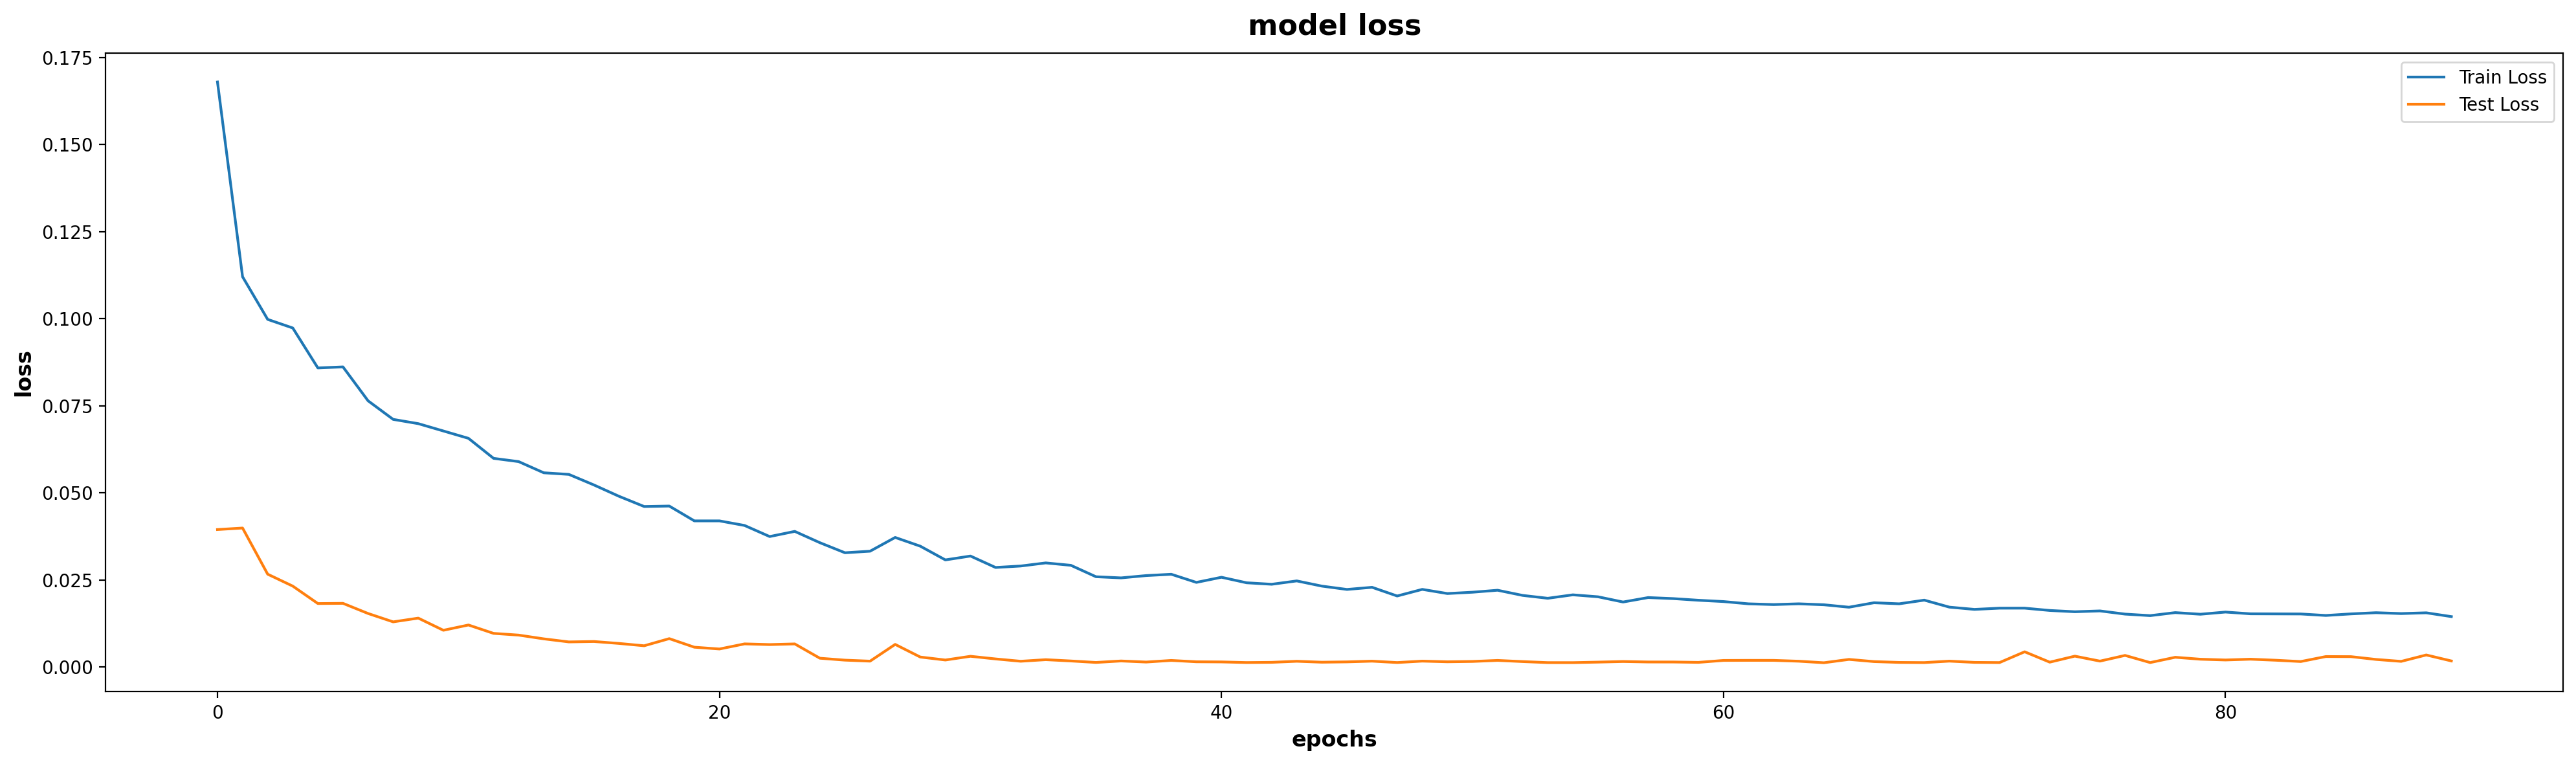

In [26]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

Train RMSE: 0.10
Test RMSE: 0.45


DateParseError: day is out of range for month: 0

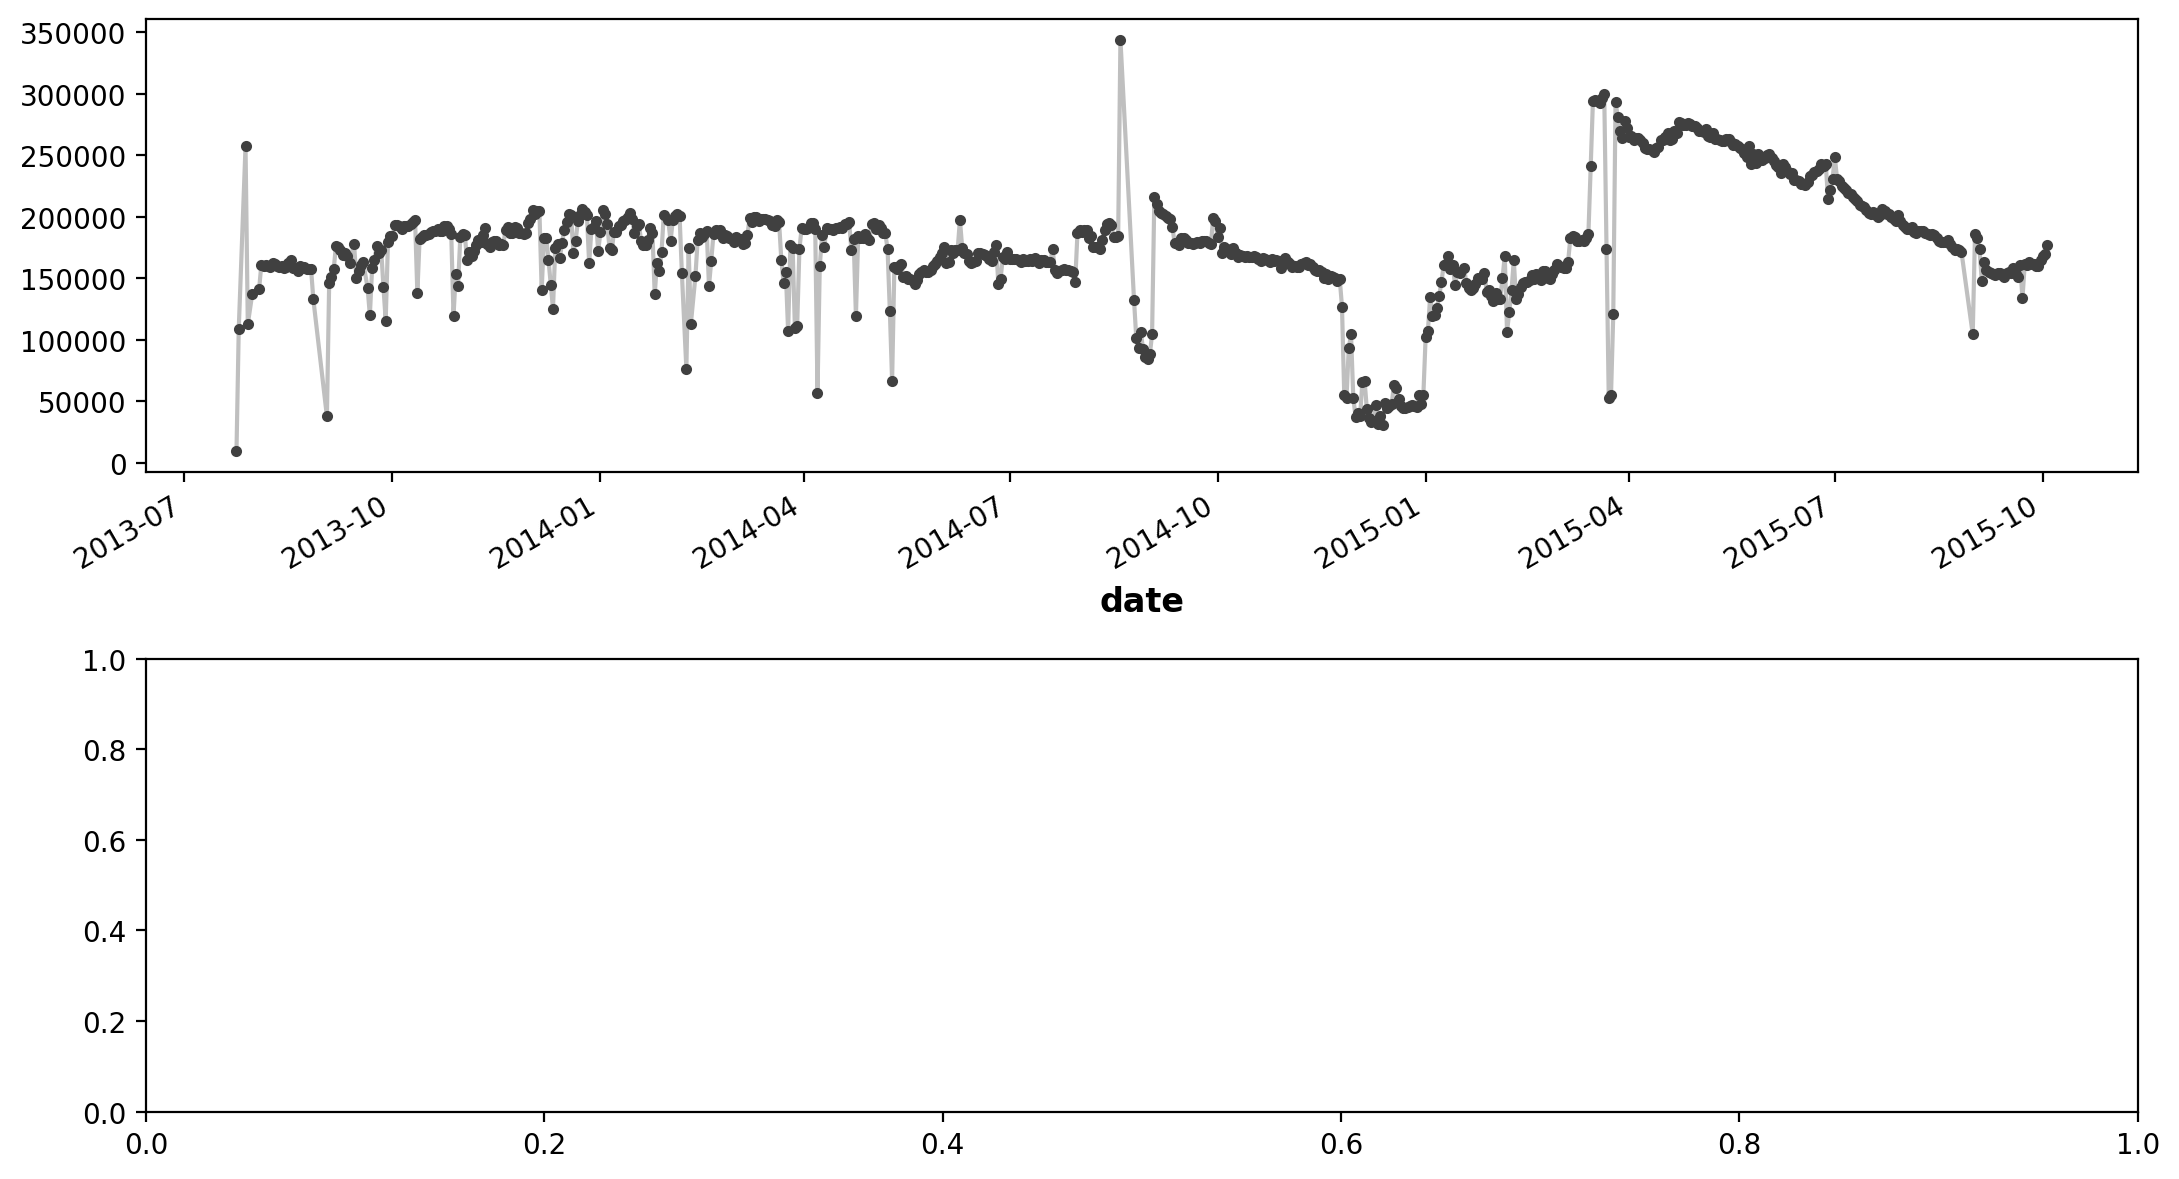

In [43]:
# y_fit = pd.DataFrame(model.predict(X_train), columns=y.columns)
# y_pred = pd.DataFrame(model.predict(X_test), columns=y.columns)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df.QG[y_train.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_train, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = df.QG[y_test.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [45]:
y_train.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       767, 768, 769, 770, 771, 772, 773, 774, 775, 776],
      dtype='int64', length=777)